# Information


This post is a functional Jupyter notebook that enables the user to calibrate an sCMOS camera. It uses [pycromanager](https://github.com/micro-manager/pycro-manager/) and [micromanager](https://micro-manager.org) to collect calibration data, and then Python code to analyze that data and video the calibration parameters. In general, it is equivalent to the approach used by Huang et al. below. The cells are filled with data from a calibration of a Hamamatsu BT Fusion sCMOS camera in `fast` mode.

Some useful reading:

* The SI of [Huang et al. (2013) Nat. Methods, DOI:10.1038/nmeth.2488](https://www.nature.com/articles/nmeth.2488)
* Janesick, J. R. Photon transfer: DN → $\lambda$. (SPIE, 2007).


## Cameras
This section describes the math behind a camera in familar terms.

Assume that are incoming photons impinging upon a single detector (i.e., on of the pixels of an sCMOS camera). The rate of those incident photons per measurement is

$$ \lambda = \lambda^\prime + \lambda^{\prime\prime} t,$$ 
where we have denoted a time independent contribution with one prime and a time-dependent contribution with two primes.

For any given time period, the probability distribution function (PDF) of the actual number of photons hitting the detector, $N$, will be Poisson-distributed with rate $\lambda$ such that 

$$ p(N \mid \lambda) = \text{Poisson}(N\mid\lambda) = \frac{\lambda^N e^{-\lambda}}{N!}.$$

without losing generality, we'll switch to using electrons instead of photons. A good camera will have a high QE, so most of the incident photon will be converted into photoelectrons, however there are also electrons generated by the camera read process (read noise) and things like (time dependent) dark-currents. So, assuming that $N$ electrons are generated on the camera pixel in question (regardless of their origin...), a camera will return a number in digital units (DU) corresponding to the number of electrons that were detected. The output signal, $y$, is generally offset from 0 by some fixed number $y_0$ to avoid 'negative' numbers in unsigned int output of the ADC. This offset addition is a deterministic process, so we can consider the camera to take a number of electrons $N$ and return a number $y-y_0$ in DU. That process is stochastic, and generally follows a normal distribution such that

$$ p(y-y_0 \mid N, \theta) = \mathcal{N}(y-y_0 \mid gN, \sigma^2), $$

where $g$ is the gain in $DU/e^{-}$, $\sigma^2$ is the read noise, and $\theta$ is a shorthand for the set of model parameters included in the conditional dependency of a statement (e.g., $g$,  $\sigma^2$, and $y_0$ here).

What we're actually interested in is the PDF of $y$ as a function of $\lambda$ regardless of the actual number of $N$. To get this, we have to perform a marginalization

$$ p(y-y_0 \mid \theta) = \sum_N p(y-y_0\mid N,\theta)\cdot p(N\mid\theta). $$

This marginalization calcuation can be performed analytically in the case that $N$ is relatively large (ie, greater than ~1000). In that situation the Poisson distribution can be approximated as a normal distribution, such that 

$$ \text{Poisson}(N\mid\lambda) \approx \mathcal{N}(N\mid \lambda,\lambda), $$
i.e., where the mean and variance of the normal distribution is the rate of the Poisson distribution. This approximation is apparent by moment matching, and more rigorously achieved by comparing the moment generating functions of the Poisson and normal distributions. 

In that situation, after integrating over N and a lot of rearranging, we find that 

$$ p(y \mid \theta) = \mathcal{N}\left(y \mid g\lambda^{\prime\prime}t + (y_0 + g\lambda^\prime), g^2\lambda^{\prime\prime}t + (\sigma^2 +g^2\lambda^\prime)\right), $$

which explicity notes the time dependence of these measurements. It's important to note that while the mean scales as $g$ and the variance scales as $g^2$, both linearly scale with $\lambda^{\prime\prime}$. In short, both the mean and the variance of the output signal of a camera pixel (under relatively high electron counts) are linear in exposure time.

When comparing to the work of Huang et al. in their SI sections one and two, we note that their sCMOS calibration protocol utilizes the same assumptions. Thus, we have the following equivalencies

| Huang et al | This work |
|-------------|-----------|
| $g_i$ | $g$ |
| $o_i$ | $(y_0 + g\lambda^\prime)$ | 
| $var_i$ | $(\sigma^2 +g^2\lambda^\prime)$ | 
| $v^k_i - var_i$ | $g^2 \lambda^{\prime\prime}t$ |
| $\bar{D^k_i}-o_i$ | $g\lambda^{\prime\prime}t$ |

Thus these calibrations are completely equivalent, although our parameterizations are little more transparent. However, instead of using their exact protocol, we provide a more convenient calculation to get $g$. Note that if $t = 0$ and/or $\lambda^{\prime\prime}=0$ (i.e., a dark movie), then we expect 

$$ p(y_{i,\text{dark}} \mid \theta) = \mathcal{N}(y_{i,\text{dark}} \mid o_i, var_i), $$
so we can obtain measurements of $y_{i,dark}$ and use any common approach to get $o_i$ and $var_i$ for each pixel. As discussed below, we use an order-statistics approach to avoid any contamination from salt noise (e.g., cosmic rays hitting the pixels), but the most common would be to use the sample mean and variance to estimate the values of $o_i$ and $var_i$.

As Huang et al. note, the estimation for $g$ can be cast as a least-squares minimization problem if we know $o_i$, $var_i$, and have a series of $y$ obtained at several different exposure times and/or illumination intensities. However, their approach requires the use a pseudo-matrix inverse and is kind of annoying to program etc. Instead, here we show the equivalent maximum likelihood estimator of this problem, which is much easier to implement. 

Note that both approaches assume for each $k^{th}$ movie acquired, that 

$$ \mathcal{N}(v^k_i-var_i \mid g(\bar{D^k_i}-o_i), \sigma^2_{least squares} ), $$

where the least squares variance is unimportant, but the same for each dataset. The MLE approach to this problem of estimating g is to take the derivative with respect to g of the log-likelihood (i.e., the product of these normal distributions), set that equal to zero, and solve for g. This gives

$$ \frac{d}{d g_i} \ln\mathcal{L}  = 0 =  \sum_k \left((v_i^k-var_i) - g(\bar{D_i^k}-o_i)\right) \cdot \left( -(\bar{D_i^k}-o_i)\right) $$ 
$$ \sum_k \left(v_i^k-var_i \right)\left( g(\bar{D_i^k}-o_i) \right) = g_i \sum_k \left( g(\bar{D_i^k}-o_i) \right)^2 $$

$$ g_{i,MLE} = \frac{ \sum_k \left(v_i^k-var_i \right)\left( g(\bar{D_i^k}-o_i) \right)} { \sum_k \left( g(\bar{D_i^k}-o_i) \right)^2} $$

Checking this with our variables, we see that 
$$ g = \frac{\sum_k (g^2\lambda^{\prime\prime}t) (g\lambda^{\prime\prime}t)}{\sum_k (g\lambda^{\prime\prime}t)^2} \sim \frac{g^3}{g^2} \sim g^1.$$

## Min-value statistics to infer normal distributions
This is a niche subject, but the idea is that if you only look at local extrema, then you can still predict the original distribution. A bit ago, I developed a pretty good approximation to the second-moment for normal distributed variables ([read about it here](http://ckinzthompson.github.io/posts/2017-06-21-maxvalue.html)). There are already good approximations to the first-moment in the literature. Thus, the approach we take is to find the local minima (here, at the same pixel, in time), calculate the sample mean and sample variance of those local minima (note, this excludes any salt noise if the local regions are large enough and salt is slow), and then use moment matching to solve for the parameters of the original normal distribution. This works very well. 

# Collect Data
The rest of the notebook can be used to perform the sCMOS camera calibration using pycromanager/micromanager. Broadly:

1. Customize the variables in the setup section
2. Cap the camera (use a very good cap!), and run the dark collection code.
3. Uncap the camera, apply light to the sensor (using a diffuser; saturate the sensor at the highest exposure), run the light collection code
4. Run the analysis code 

## Setup
Customize the variables below for your system

In [93]:
import numpy as np

## This is a temporary file for each individual movie. Make sure the disk has enough space to hold one movie at a time.
## It will automatically be deleted.
fdir = r'C:\Users\ptirf\Desktop'
fname = r'temp'

## Number of frames to collect -- nb, you really want to have the dark movie dialed in, so use more datapoints there.
npoints_light = 1000
npoints_dark  = 5000

## Automatically set these imaging parameters at the beginning of each acquisition
properties = [
    ['HamamatsuHam_DCAM','ScanMode',3],
    ['HamamatsuHam_DCAM','Binning','2x2'],
]

## Define the exposures to use. nb, often must be given in msec not sec....
exposure_properties = ['HamamatsuHam_DCAM','Exposure']
exposures = 10**np.linspace(-4,-1,13) * 1000 ## msec
print('Light Exposures (msec):',exposures)

dark_exposure = 0.01 * 1000 ## msec
print('Dark Exposure (msec):',dark_exposure)


## This script uses min-value order statistics to avoid salt noise. 
## `nskip` is how many frames to look across when finding each minima.
nskip = 10


Light Exposures (msec): [  0.1          0.17782794   0.31622777   0.56234133   1.
   1.77827941   3.16227766   5.62341325  10.          17.7827941
  31.6227766   56.23413252 100.        ]
Dark Exposure (msec): 10.0


### Microscope Code

### Software 
Note, getting pycromanager working required matching micro-manager and pycromanager version. The trick was to go to pypi (pycromanager is installed using pip), and find out the day when the latest release was released. Then go to the daily builds download of micro-manager and download the daily build from the closest/best matched day.

For instance, in November 2023, the latest pycromanager release version was 0.29.9, which was put out on (September 29,2023)[https://pypi.org/project/pycromanager/#history]. The (latest nightly build)[https://download.micro-manager.org/nightly/2.0/Windows/] of micromanger failed, so going back to the 9/29/2023 release worked. 

### Approach
This approaches uses min-value order statistics to estimate the gaussian distribution of intensities for each pixel. This approach is to avoid salt noise. It uses (my own moment-matching approximation)[http://ckinzthompson.github.io/posts/2017-06-21-maxvalue.html].

Also, it excludes the first frame of every *tif* file (i.e., if your movie is split across many files, several frames are skipped). This is because it was too much work to figure out which tif file is the actual first of such a series. In that first movie,the first frame seems to be overexposed on my camera and *must* be skipped. Skipping all the first frames is the quickest solution.

Also, each movie is acquired, processed, and then deleted. Processing algorithms keep the movie data as `uint16` to save memory. The maximum memory use is when locating the local minima, a copy of `size/nskip` is made while the original data is around, so that should be 1.1x the file size if using `nskip=10`. Also note that all tif files contribute to the mean and var (the expectation values of $E[x]$ and $E[x^2]$ are acquired in an online approach, and the mean and var are calculated from them at the end). 

### Timing
The processing seems to be the rate-limiting step. Could probably speed up by running pixels in parallel (i.e. `nb.prange`).

In [61]:
import numpy as np
import numba as nb
from scipy.special import ndtri

@nb.njit
def collect_t_mins(d,l):
    if d.ndim == 2:
        raise Exception('d should be 3d')
    nt,nx,ny = d.shape
    mt = nt//l
    
    out = np.zeros((mt,nx,ny),dtype='uint16')
    for i in range(nx):
        for j in range(ny):
            for k in range(mt):
                out[k,i,j] = np.min(d[k*l:(k+1)*l,i,j])
    return out

@nb.njit
def online_expectations(d):
    ## the point is the d should stay a uint16 array for memory issues...
    nt,nx,ny = d.shape
    out = np.zeros((2,nx,ny),dtype='double')
    dtij = 0.
    for t in range(nt):
        for i in range(nx):
            for j in range(ny):
                dtij = float(d[t,i,j])
                out[0,i,j] += dtij
                out[1,i,j] += dtij*dtij
    return out
                
def online_normal_stats(tifs,nskip):
    '''
    take a list of tif filenames and return the mean and var per pixel image of all together
    uses online approx, min-value statistics, and keeps everything uint16 for memory purposes
    '''
    #### Calculate the mean and variance of each pixel, including ALL the tif file parts
    ## Note, there are some improvements to make:
    ## - the first frame from every file is skipped -- only need to skip it for first file to avoid weird artifacts

    
    ntifs = len(tifs)
    ns = np.zeros((ntifs))
    for i in range(ntifs):
        ## skip the first time point -- only for movie one but idk which that is now (note, not nec. the first filename in list)
        tif = tifs[i]
        d = tifffile.imread(tifs[i])[1:]

        d = collect_t_mins(d,nskip)
        nt,nx,ny = d.shape
        if i == 0:
            expectations = np.zeros((ntifs,2,nx,ny))
        expectations[i] = online_expectations(d)
        ns[i] = nt
    expectations = expectations.sum(0)
    ns = np.sum(ns)
    mean = expectations[0]/ns
    var = expectations[1]/ns - mean**2.
    
    ## use min-value statistics to get actual distribution
    alpha = 0.375
    factor_mean = ndtri((nskip-alpha)/(nskip-2.*alpha+1.))
    a = .85317
    b = -.573889
    factor_var = np.log(nskip)/(a+b/nskip)
    
    tv = var * factor_var
    tm = mean + factor_mean*np.sqrt(tv)
    
    return tm,tv


In [62]:
from pycromanager import Acquisition, Core, multi_d_acquisition_events
import numpy as np
import tifffile
import shutil
import time
import os

def microscope_expose(npoints,exposure,exposure_properties,properties,fdir,fname='temp',nskip=10):
    ## Setup MMCore
    core = Core()

    ## Set camera properties
    for prop in properties:
        core.set_property(prop[0],prop[1],prop[2])

    ## Set the exposure
    core.set_property(exposure_properties[0],exposure_properties[1],exposure)
    time.sleep(.5) ## Make sure it kicks in
    print('Running', core.get_property(exposure_properties[0],exposure_properties[1]))

    ## Start the acquisition - store it in as .tif files that will be removed 
    ## Originally wanted to do this completely in memory.... bugs?
    with Acquisition(directory=fdir,name=fname,debug=False,core_log_debug=False,show_display=False) as acq:
        events = multi_d_acquisition_events(num_time_points=npoints, time_interval_s=0.)
        acq.acquire(events)

    ## Make sure we close the dataset? 
    dataset = acq.get_dataset()
    path = dataset.path
    dataset.close()

    ## Get all the NDTiff files -- large files are split over several individual files
    tifs = [os.path.join(path, tif) for tif in os.listdir(path) if tif.endswith(".tif")]

    ## get statistics
    print('Calculating',len(tifs),path)
    mean,var = online_normal_stats(tifs,nskip)

    ## Remove the tif data
    shutil.rmtree(path)
    
    return mean,var

## Acquire Dark

Turn the light off and make sure absolutely no light makes it to the detector. Probably you should just unhook the camera and put the cap on it... do it. don't be lazy. Also, plastic caps seem to let light in?

In [63]:
## Collect data, calculate statistics, then remove data
t0 = time.time()
mean,var = microscope_expose(npoints_dark,dark_exposure,exposure_properties,properties,fdir,fname,nskip)
out = np.array([[mean,var],])

## Save the real data
t1 = time.time()

out = np.array(out)
np.save(os.path.join(fdir,'dark_data.npy'),out)
print('Done %.3f sec'%(t1-t0))
print(out.shape)

Running 10.0010
Calculating 4 C:\Users\ptirf\Desktop\temp_1\
Done 185.981 sec
(1, 2, 1152, 1152)


## Acquire Light

Make sure to go to the top exposure time, and tune the light source to so that nearly all of the pixels are at the ADC maximum (i.e., $2^{16}-1=65535$). Also, make sure to remove any image splitters to make sure all pixels are getting a comparable amount of light. 

My setup: 
1. I took a piece of plastic (cut from a petri dish plate)
2. Scratched it up to be a diffuser added a piece of black masking tape b/c it was allowing too much light
3. Placed that over the camera opening
4. Placed kim-wipes on top of that to act as diffusers
5. Placed the mask tape roll on top of the kimwipes to keep them from blowing around
6. Positioned an LED point down onto the camera.
7. Tuned the light source to saturate the camera at the maximum exposure (0.1 sec here...) using the micromanager live preview histogram



In [64]:
out = []

time.sleep(20) ## for you to get out of the room...
t0 = time.time()
for exposure in exposures:
    ## Collect data, calculate statistics, then remove data
    mean,var = microscope_expose(npoints_light,exposure,exposure_properties,properties,fdir,fname,nskip)
    out.append([mean,var])
    
## Save the real data
t1 = time.time()
out = np.array(out)
np.save(os.path.join(fdir,'light_data.npy'),out)
np.save(os.path.join(fdir,'light_exposures.npy'),exposures)

print('Done %.3f sec'%(t1-t0))

Running 0.1000
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 0.1780
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 0.3190
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 0.5620
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 1.0000
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 1.7790
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 3.1670
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 5.6250
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 10.0010
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 17.7840
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 31.6230
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 56.2380
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Running 100.0030
Calculating 1 C:\Users\ptirf\Desktop\temp_1\
Done 666.046 sec


# Analyze Data

## Load the Data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

fdir = './' #fdir
fname_exposures = os.path.join(fdir,'light_exposures.npy')
fname_light_data = os.path.join(fdir,'light_data.npy')
fname_dark_data = os.path.join(fdir,'dark_data.npy')

# ### in case they're non-standard files...
# fname_exposures  = 'light3_exposures.npy'
# fname_light_data = 'light3_means_vars.npy'
# fname_dark_data  = 'dark3_means_vars.npy'

exposures = np.load(fname_exposures)
light_data = np.load(fname_light_data)
dark_data = np.load(fname_dark_data)


exposures = exposures/1000. ## they are given in msec

## Isolate linear response region
Figure out which datapoints don't look like the expected gaussians -- only take the region where increasing exposure time produces a linear change (i.e., below around 1000 electrons you have poisson noise and the normal approximation is bad; above ~60k electrons and many of the pixel ADCs will saturate)

In [4]:
#### These will be excluded
cut_lower = 1400   ## the 2x2 binning offet is 400, so ...
cut_upper = 55000  ## the camera has a 16-bit ADC .... so 65535 max

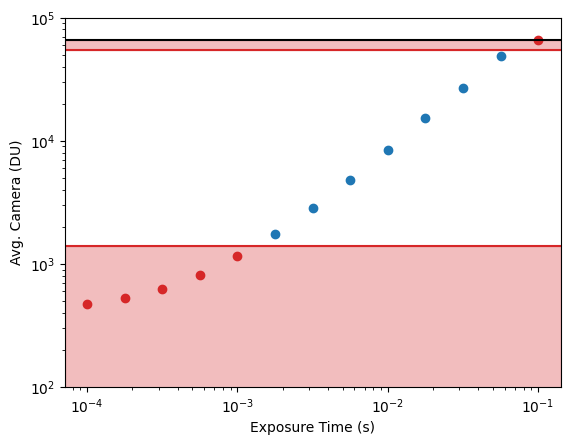

In [5]:
mu = light_data[:,0].mean((1,2))
last = mu > cut_upper

keep = np.bitwise_and(mu > cut_lower, mu < cut_upper)
if np.sum(last) > 0:
    keep[np.argmax(last):] = False
notkeep = np.bitwise_not(keep)

if keep.sum() > 0:
    plt.loglog(exposures[keep],mu[keep],'o',color='tab:blue')
if notkeep.sum() > 0:
    plt.loglog(exposures[notkeep],mu[notkeep],'o',color='tab:red')

plt.axhline(y=65535,color='black')
plt.axhspan(ymin = 1, ymax = cut_lower,color='tab:red',alpha=.3)
plt.axhline(y=cut_lower,color='tab:red')
plt.axhspan(ymin = cut_upper, ymax = 2**16-1,color='tab:red',alpha=.3)
plt.axhline(y=cut_upper,color='tab:red')

plt.ylim(10**2,10**5)
plt.ylabel('Avg. Camera (DU)')
plt.xlabel('Exposure Time (s)')
plt.show()

## Calculate the calibrations
Note, Huang et al use least squares and a matrix based solver that involves pseudo-inverses. To avoid all of that, you can just use the maximum-likelihood estimator (MLE) version of that calculation used here.

Notes for this camera (Hamamatsu BT Fusion):

* It looks like I need to redo the illumination and/or dark image, because there are rings in the gain image
* There are weird pixels on this camera at the top (column-wise read out amplifiers?), and on one edge (idk). These can be excluded by slicing `[128:,:-128]` for the 2x2 binnned images here. Note this brings this camera down to a 1024x1024 or 2048x2048 image. Also, the manual says that running at such a size ROI gets a reasonable speed boost, so maybe I'll do this is the future.
* This data is in imaging mode 3 (fast).


In [6]:
## These labels follow Huang et al.
o = dark_data[0,0]
var = dark_data[0,1]

## they use least squares, here is the MLE version 
g = np.sum((light_data[keep,1] - var[None,:,:])*(light_data[keep,0] - o[None,:,:]),axis=0)/np.sum((light_data[keep,0] - o[None,:,:])**2.,axis=0)

print(o.shape,var.shape,g.shape)

(1152, 1152) (1152, 1152) (1152, 1152)


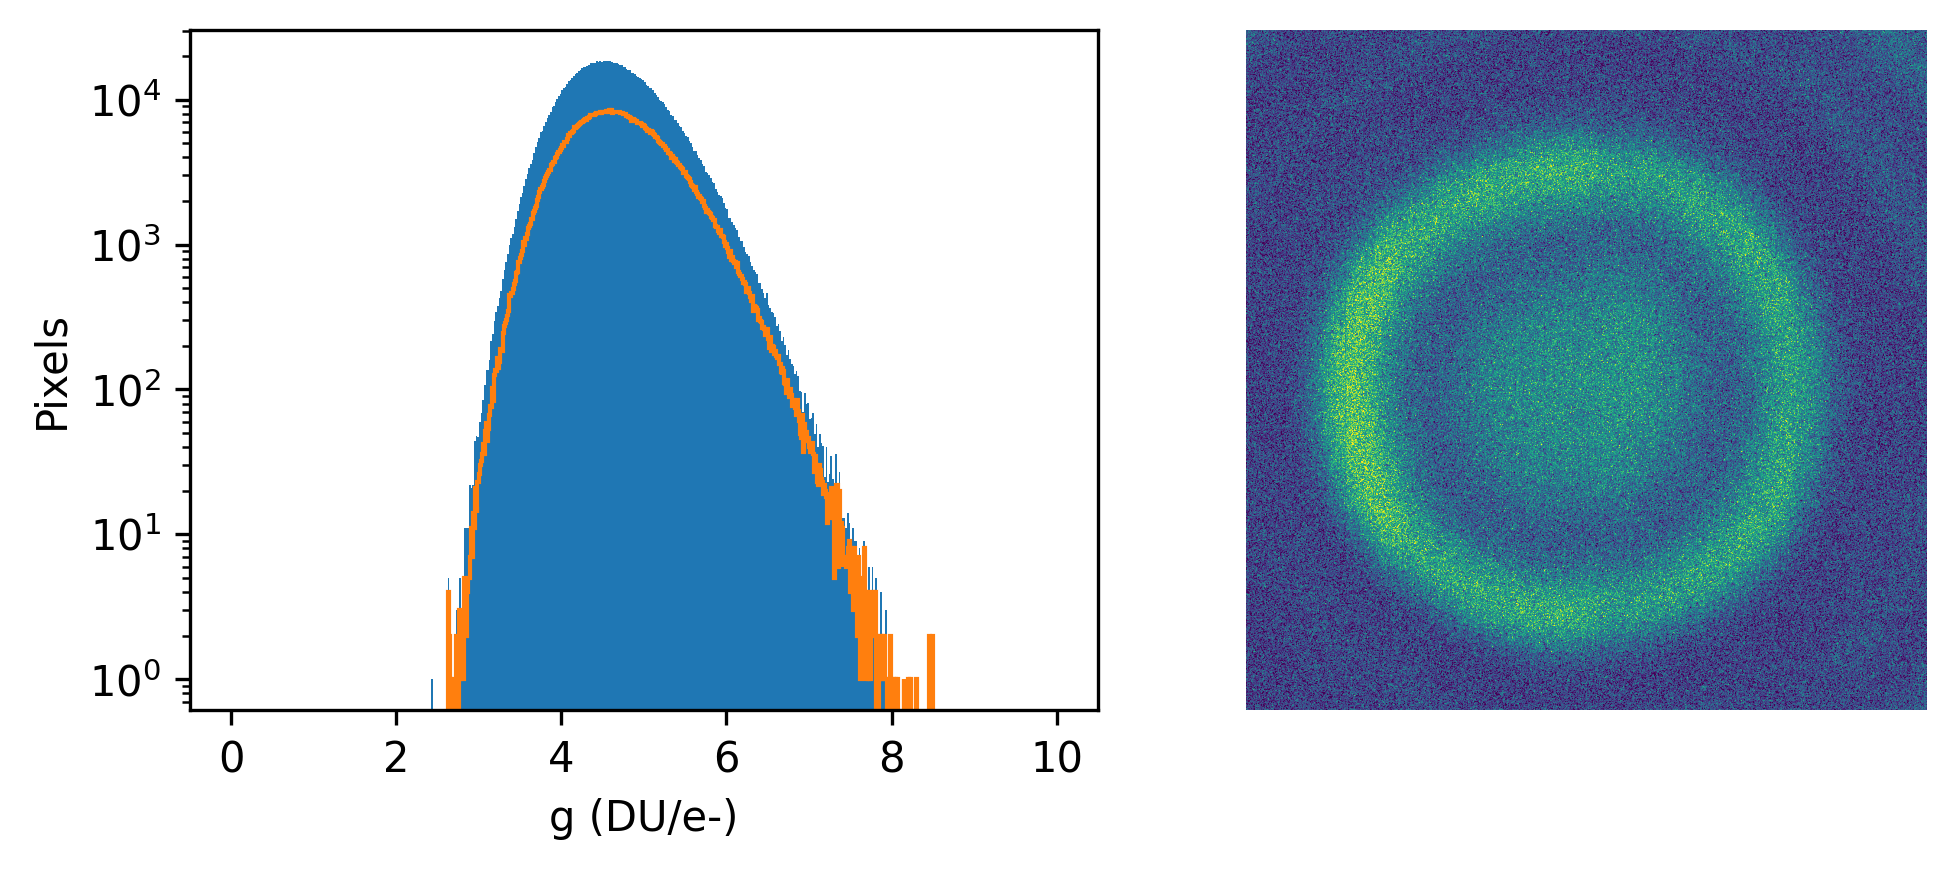

Maximum: 4.46


In [7]:
fig,ax = plt.subplots(1,2,figsize=(7,3),dpi=300)
hy,hx = ax[0].hist(g.flatten(),bins=500,log=True,range=(0,10),color='tab:blue')[:2]
ax[0].hist(g[128:,:-128].flatten(),bins=500,log=True,histtype='step',color='tab:orange')
ax[1].imshow(g,vmin=4,vmax=6)
ax[0].set_xlabel('g (DU/e-)')
ax[0].set_ylabel('Pixels')
ax[1].axis('off')
fig.tight_layout()
plt.show()

peak_g = hx[hy.argmax()]
print('Maximum:',peak_g)

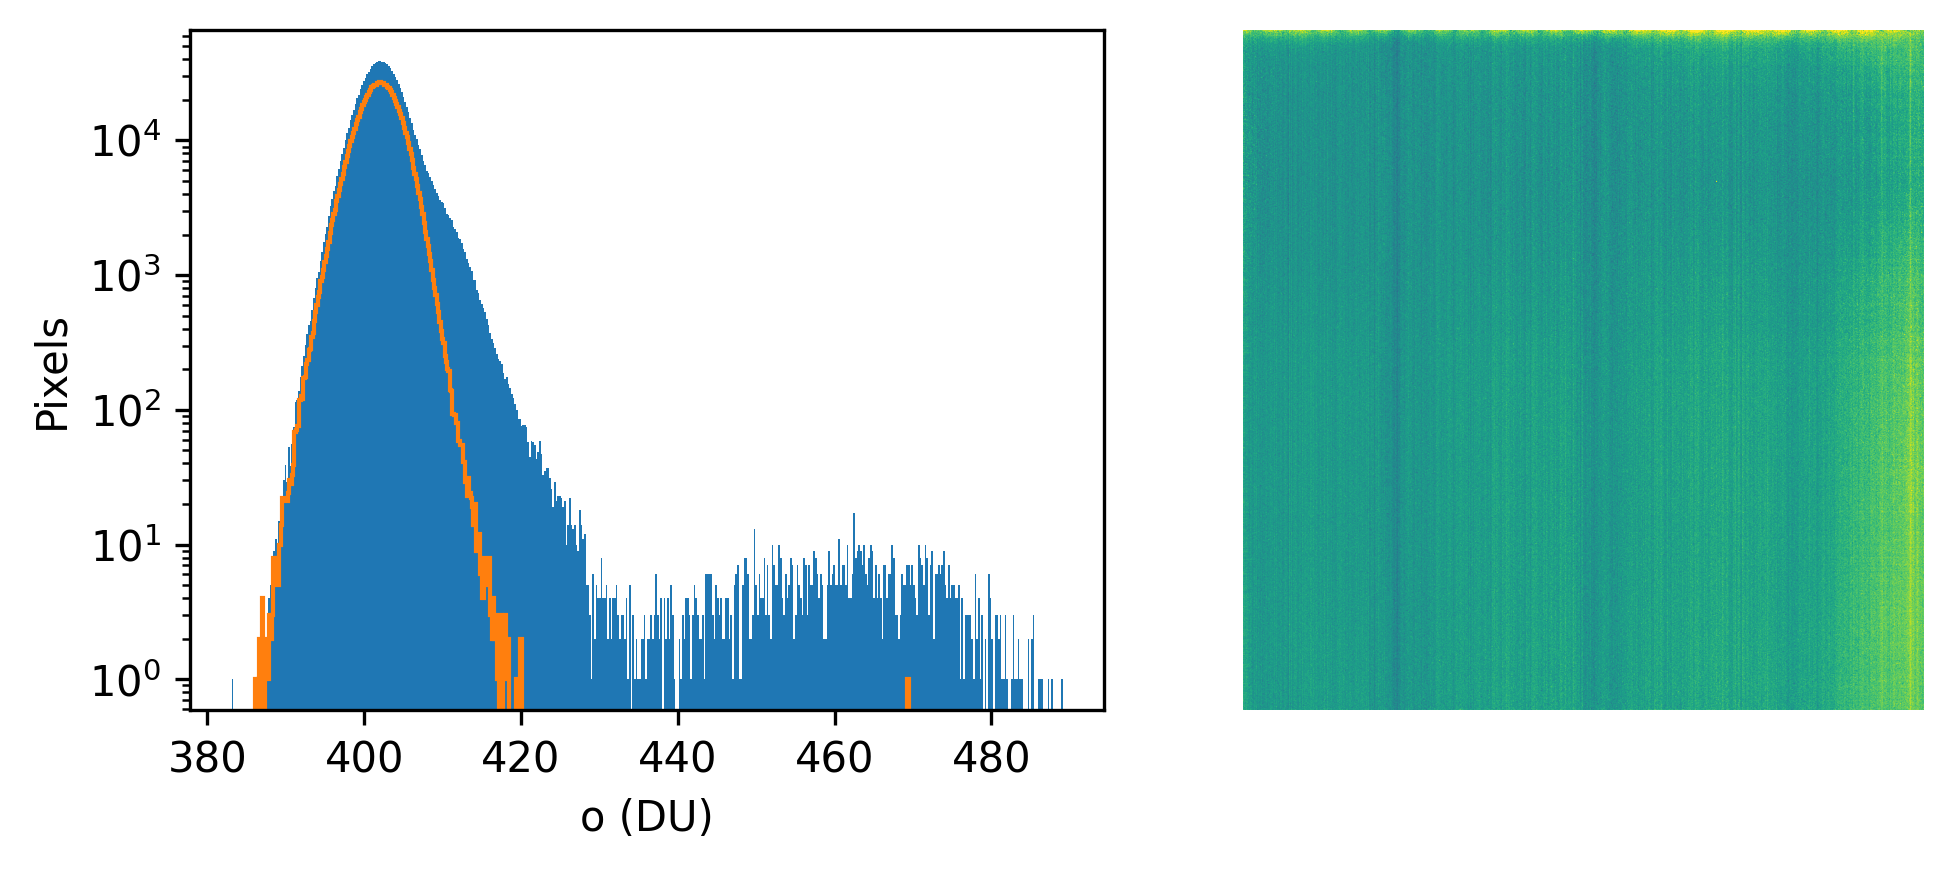

Maximum: 401.9556435675076


In [8]:
fig,ax = plt.subplots(1,2,figsize=(7,3),dpi=300)
hy,hx = ax[0].hist(o.flatten(),bins=500,log=True,color='tab:blue')[:2]
ax[0].hist(o[128:,:-128].flatten(),bins=500,log=True,histtype='step',color='tab:orange')
ax[1].imshow(o,vmin=380,vmax=420)
ax[0].set_xlabel('o (DU)')
ax[0].set_ylabel('Pixels')
ax[1].axis('off')
fig.tight_layout()
plt.show()

peak_o = hx[hy.argmax()]
print('Maximum:',peak_o)

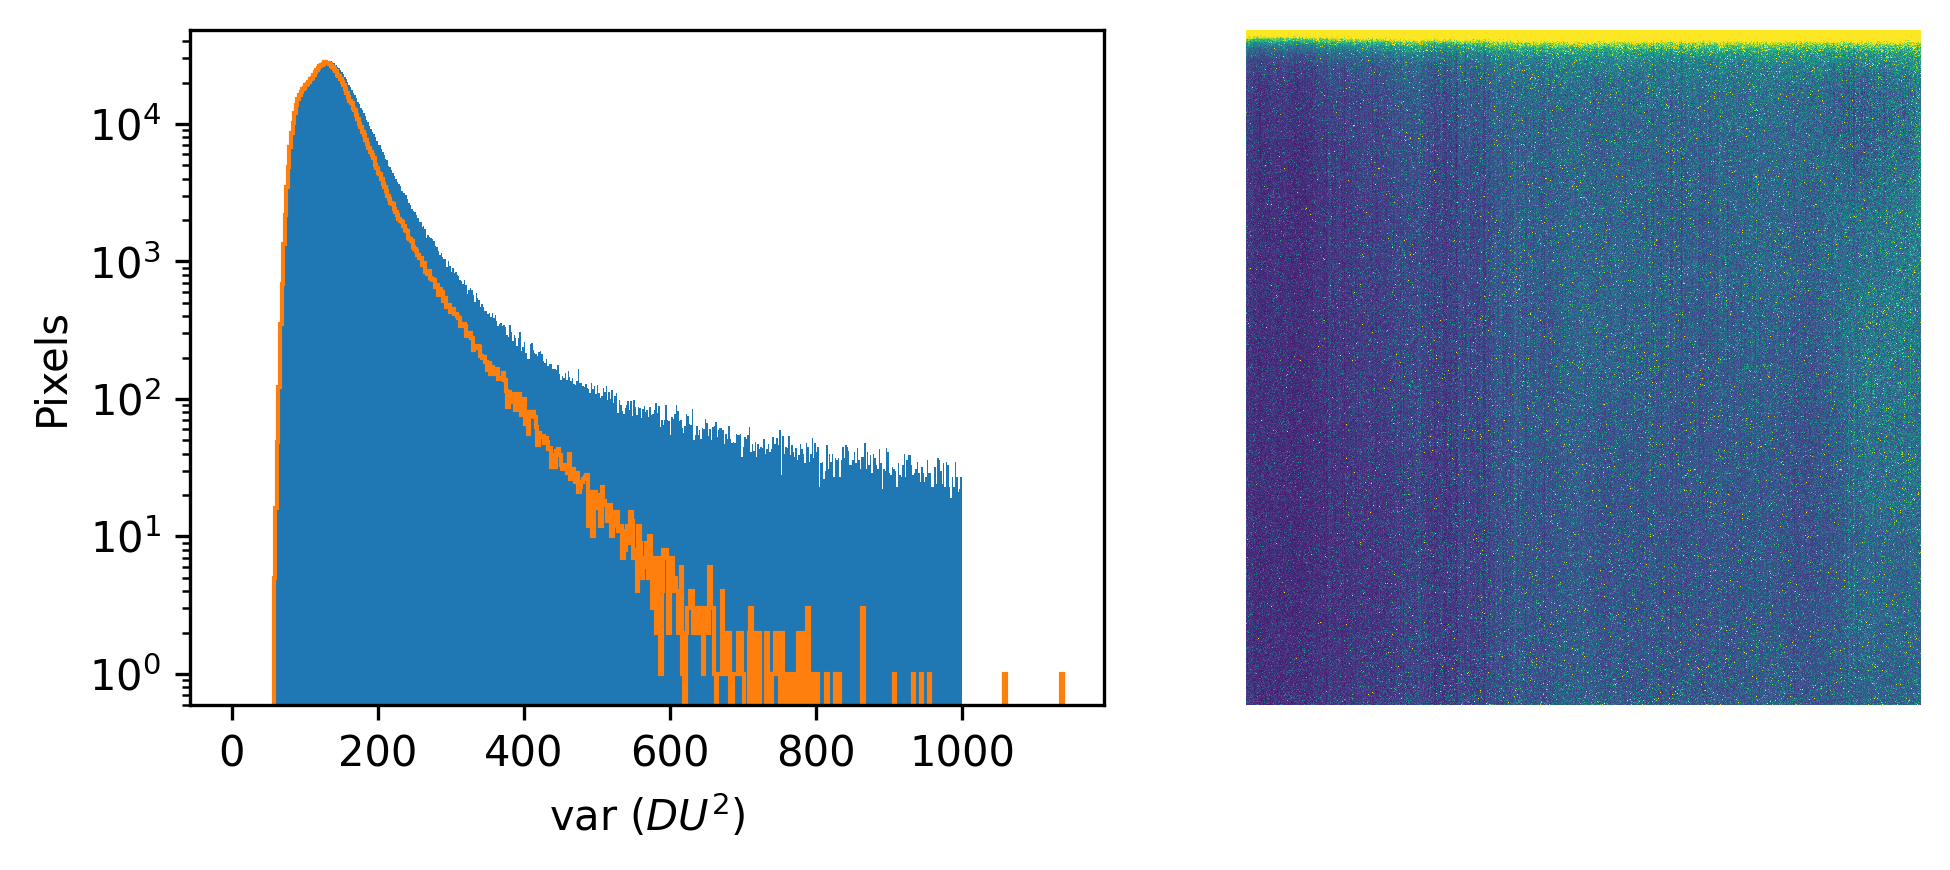

Maximum: 132.0
Noisy electrons: 2.5760370612278156


In [9]:
fig,ax = plt.subplots(1,2,figsize=(7,3),dpi=300)
hy,hx = ax[0].hist(var.flatten(),bins=500,log=True,range=(0,1000),color='tab:blue')[:2]
ax[0].hist(var[128:,:-128].flatten(),bins=500,log=True,histtype='step',color='tab:orange')
ax[1].imshow(var,vmin=50,vmax=400,interpolation='nearest')
ax[0].set_xlabel(r'var ($DU^2$)')
ax[0].set_ylabel('Pixels')
ax[1].axis('off')
fig.tight_layout()
plt.show()

peak_var = hx[hy.argmax()]
print('Maximum:',peak_var)
print('Noisy electrons:',np.sqrt(peak_var)/peak_g)

In [12]:
### Save the calibration
print('Saving calibrations (individual and global)')
print('g:   %.3f'%(peak_g))
print('o:   %.3f'%(peak_o))
print('var: %.3f'%(peak_var))

out = np.array([g,o,var,])
np.save('calibration_individual.npy',out)

out = np.array([g*0.+peak_g,o*0.+peak_o,var*0+peak_var])
np.save('calibration_global.npy',out)

Saving calibrations (individual and global)
g:   4.460
o:   401.956
var: 132.000


## Analyze the calibrations

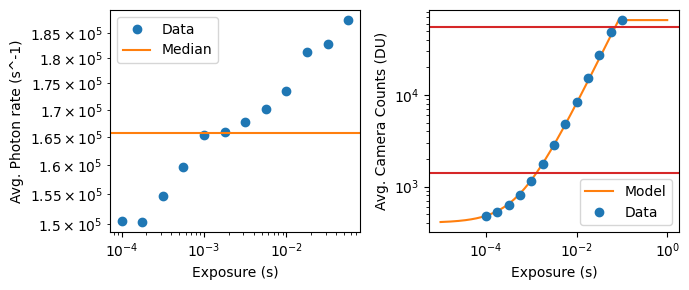

In [13]:
fig,ax = plt.subplots(1,2,figsize=(7,3))

avgphotons = (light_data[:,0]-o)/g
lam = np.median((np.median(avgphotons,axis=(1,2))/exposures)[:-1])
ax[0].loglog(exposures[:-1],(np.mean(avgphotons,axis=(1,2))/exposures)[:-1],'o',color='tab:blue',label='Data')
ax[0].axhline(y=lam,color='tab:orange',label='Median')
ax[0].set_xlabel('Exposure (s)')
ax[0].set_ylabel('Avg. Photon rate (s^-1)')
ax[0].legend()

t = 10**np.linspace(np.log10(exposures[0])//1-1,np.log10(exposures[-1])//1+1,1000)
yy = g.mean()*lam*t+o.mean()
yy[yy>=2**16-1] = 2**16-1
ax[1].loglog(t,yy,label='Model',color='tab:orange')
ax[1].loglog(exposures,light_data[:,0].mean((1,2)),'o',label='Data',color='tab:blue')
ax[1].legend()

ax[1].axhline(y=cut_lower,color='tab:red')
ax[1].axhline(y=cut_upper,color='tab:red')

ax[1].set_ylabel('Avg. Camera Counts (DU)')
ax[1].set_xlabel('Exposure (s)')
fig.tight_layout()
plt.show()


### Notes

The Hamamatsu BT Fusion documations quotes read noise levels as: 

* mode 3 (fast): 1.6 RMS e-
* mode 2 (standard): 1.0 RMS e-
* mode 1 (ultra-quiet): 0.7 RMS e-
